## 5_GEM_MOM
创业板动能因子选股

## Step1 获得创业板的股票代码

In [1]:
from fxdayu_data import DataAPI
from datetime import datetime
import tushare as ts
import numpy as np
import talib as ta
# from sklearn import preprocessing
import matplotlib.pyplot as plt
import pandas as pd

DataAPI.set_file('D:/PycharmProjects/Quant_Alpha/Data_Manager/Valuation_Selection/config.py')

def coder(code):
    if code.startswith('6'):
        return code + '.XSHG'
    elif code.startswith('0') or code.startswith('3'):
        return code + '.XSHE'
    else:
        return code


gem = ts.get_gem_classified()
gem_list = list(gem.code)
codes = tuple(map(coder, gem_list))
print(codes[0])

[Errno 2] No such file or directory: 'config.py'
300001.XSHE


## Step2 获得因子的Panel与DataFrame

In [2]:
PN = DataAPI.factor(codes, 'close', start=datetime(2010, 1, 1))
prices = PN.minor_xs('close')

print PN
print prices

<class 'pandas.core.panel.Panel'>
Dimensions: 648 (items) x 1806 (major_axis) x 1 (minor_axis)
Items axis: 300001.XSHE to 300665.XSHE
Major_axis axis: 2010-01-04 15:00:00 to 2017-06-13 15:00:00
Minor_axis axis: close to close
                     300001.XSHE  300002.XSHE  300003.XSHE  300004.XSHE  \
datetime                                                                  
2010-01-04 15:00:00        6.148        6.962       12.092        9.660   
2010-01-05 15:00:00        6.151        7.171       12.130        9.552   
2010-01-06 15:00:00        6.022        7.135       11.918        9.220   
2010-01-07 15:00:00        6.006        6.870       11.670        9.301   
2010-01-08 15:00:00        5.823        6.980       11.221        8.979   
2010-01-11 15:00:00        5.933        7.528       11.153        8.893   
2010-01-12 15:00:00        6.019        7.773       11.409        9.083   
2010-01-13 15:00:00        6.078        7.841       11.256        9.149   
2010-01-14 15:00:00     

## Step3 计算因子值

In [3]:
mom_factor = pd.DataFrame({name: -1*ta.ROCR(item.values, 15) for name, item in prices.iteritems()}, index=prices.index)
factor = mom_factor.stack()
print factor

datetime                        
2010-01-25 15:00:00  300001.XSHE   -0.896389
                     300002.XSHE   -0.957340
                     300003.XSHE   -0.814423
                     300004.XSHE   -0.852381
                     300005.XSHE   -0.951816
                     300006.XSHE   -0.843927
                     300007.XSHE   -0.875244
                     300008.XSHE   -0.917528
                     300009.XSHE   -0.830528
                     300010.XSHE   -0.881537
                     300011.XSHE   -0.983238
                     300012.XSHE   -0.873838
                     300013.XSHE   -0.874112
                     300014.XSHE   -0.835923
                     300015.XSHE   -0.892216
                     300016.XSHE   -0.833768
                     300017.XSHE   -0.913377
                     300018.XSHE   -0.860013
                     300019.XSHE   -0.896439
                     300020.XSHE   -0.883991
                     300021.XSHE   -0.821945
                     3

## Step 4 因子数据输入Alphalens,输出股票池。

In [4]:
import alphalens

factor_data = alphalens.utils.get_clean_factor_and_forward_returns(factor, prices, quantiles=5)
cond = factor_data['factor_quantile'] == 5
save = factor_data[cond]
s = pd.Series(True, index=save.index)
s = s.unstack()
s[s != True] = False
s.to_excel('D:/PycharmProjects/Quant_Alpha/Momentun_Hedge/GEM_MOM.xlsx')
print(s)

asset               300001.XSHE 300002.XSHE 300003.XSHE 300004.XSHE  \
date                                                                  
2010-01-25 15:00:00       False       False        True       False   
2010-01-26 15:00:00       False       False        True       False   
2010-01-27 15:00:00       False       False        True       False   
2010-01-28 15:00:00       False       False       False       False   
2010-01-29 15:00:00       False       False       False       False   
2010-02-01 15:00:00       False       False       False       False   
2010-02-02 15:00:00       False       False       False       False   
2010-02-03 15:00:00       False       False       False       False   
2010-02-04 15:00:00       False       False       False       False   
2010-02-05 15:00:00       False       False       False       False   
2010-02-08 15:00:00       False       False       False       False   
2010-02-09 15:00:00        True       False       False       False   
2010-0

## Step 5 显示Quantile累积收益与IC值

D:\ProgramData\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
D:\ProgramData\Anaconda2\lib\site-packages\alphalens\plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))


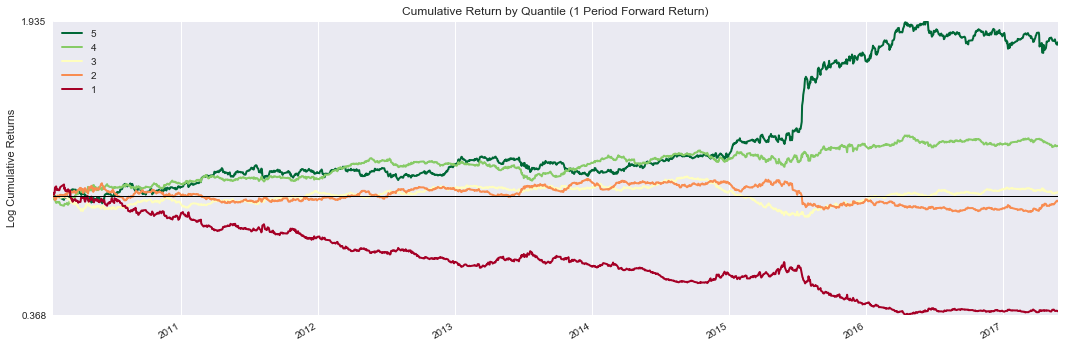

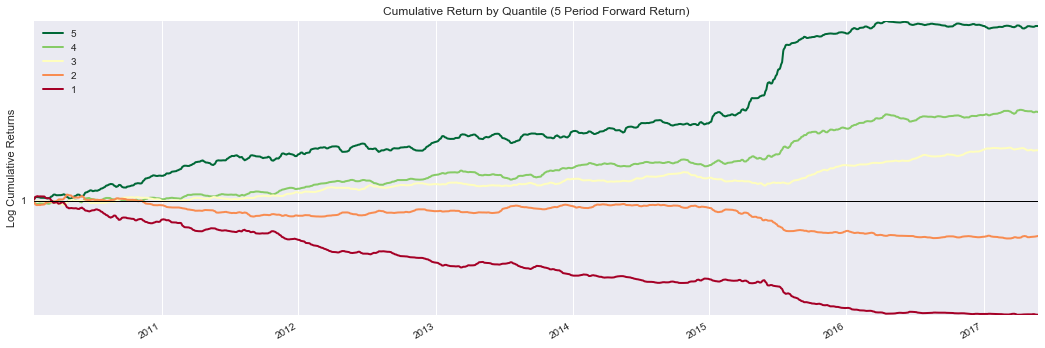

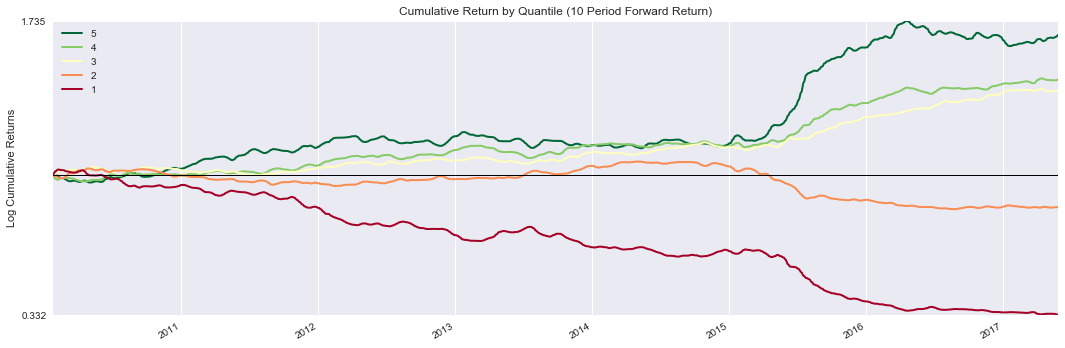

In [5]:
mean_return_by_q, std_err_by_q = alphalens.performance.mean_return_by_quantile(factor_data, by_date=True)

alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 1)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 5)
alphalens.plotting.plot_cumulative_returns_by_quantile(mean_return_by_q, 10)
plt.show()

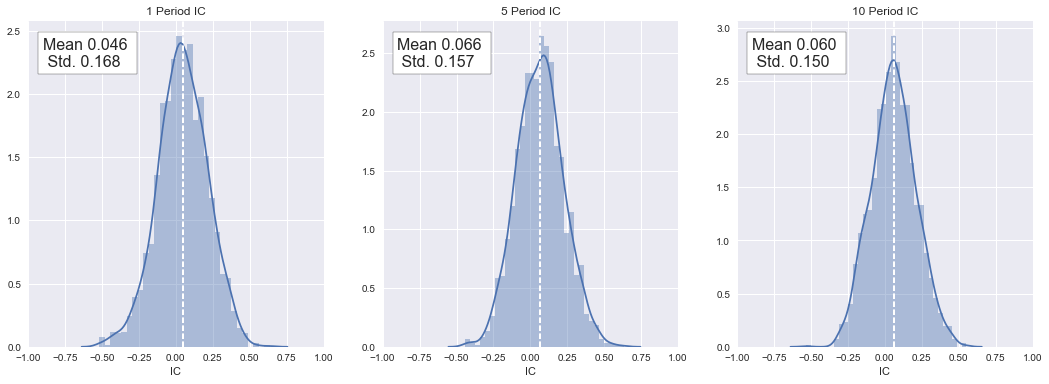

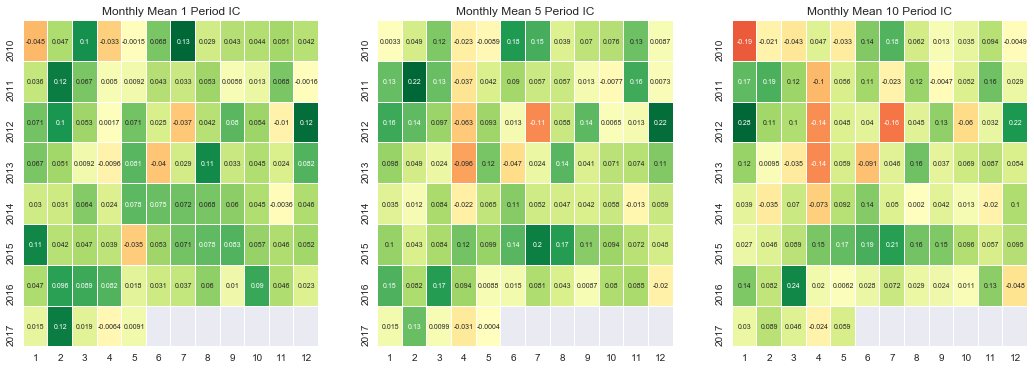

In [6]:
ic = alphalens.performance.factor_information_coefficient(factor_data)
# print ic
alphalens.plotting.plot_ic_hist(ic)
mean_monthly_ic = alphalens.performance.mean_information_coefficient(factor_data, by_time='M')
# print mean_monthly_ic.mean()
alphalens.plotting.plot_monthly_ic_heatmap(mean_monthly_ic)
plt.show()